<a href="https://colab.research.google.com/github/Adrita2211/ML_Project/blob/main/click-stream-data-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import ast

In [30]:
clickStreamData = pd.read_excel("/content/sample_data/click_stream_new.xlsx", engine='openpyxl')

In [31]:
df = pd.DataFrame(clickStreamData)

In [32]:
df.head()

,session_id,event_name,event_time,event_id,traffic_source,event_metadata
0,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,HOMEPAGE,2019-09-06T15:54:32.821085Z,9c4388c4-c95b-4678-b5ca-e9cbc0734109,MOBILE,NaN
1,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,SCROLL,2019-09-06T16:03:57.821085Z,4690e1f5-3f99-42d3-84a5-22c4c4d8500a,MOBILE,NaN
2,7d440441-e67a-4d36-b324-80ffd636d166,HOMEPAGE,2019-09-01T12:05:10.322763Z,88aeaeb5-ec98-4859-852c-8abb483faf31,MOBILE,NaN
3,7d440441-e67a-4d36-b324-80ffd636d166,ADD_TO_CART,2019-09-01T12:06:33.322763Z,934e306e-ecc6-472f-9ccb-12c8536910a2,MOBILE,"{'product_id': 15315, 'quantity': 4, 'item_pri..."
4,7d440441-e67a-4d36-b324-80ffd636d166,BOOKING,2019-09-01T12:15:29.425431Z,9f4767a1-40fa-4c9c-9524-dfad18634d56,MOBILE,{'payment_status': 'Success'}


In [33]:
df['event_time'] = pd.to_datetime(df['event_time'])

In [ ]:
def clean_duplicate_path(path):
    # Remove consecutive duplicate events
    cleaned = []
    for event in path:
        if not cleaned or event != cleaned[-1]:
            cleaned.append(event)
    return cleaned

# Group by session_id and collect events in order
paths = df.groupby('session_id').apply(
    lambda x: clean_duplicate_path(x.sort_values('event_time')['event_name'].tolist())
)

# Filter only paths that end with BOOKING
booking_paths = paths[paths.apply(lambda x: x[-1] == 'BOOKING')]

# Get unique paths
unique_booking_paths = booking_paths.drop_duplicates()

<ipython-input-34-4baae5766a58>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  paths = df.groupby('session_id').apply(


In [ ]:
print(unique_booking_paths)

session_id
00001f29-3ede-4445-95f0-0178934e32ba    [HOMEPAGE, ADD_TO_CART, HOMEPAGE, CLICK, ITEM_...
0001971f-84ae-4bac-9612-366c5f241167    [HOMEPAGE, SEARCH, ADD_TO_CART, SCROLL, ADD_PR...
000288dc-e7cf-44b9-9f2d-270015fd83c6    [HOMEPAGE, ITEM_DETAIL, ADD_TO_CART, SEARCH, C...
0002ad9d-3c59-4c9c-b6dc-ae6a561ef718             [HOMEPAGE, SCROLL, ADD_TO_CART, BOOKING]
00049358-f228-48ad-b0f2-37d92cc93c0c                     [HOMEPAGE, ADD_TO_CART, BOOKING]
                                                              ...                        
fff48397-a528-4c4f-abfc-71402e57461a    [HOMEPAGE, SEARCH, ADD_TO_CART, SEARCH, ADD_PR...
fff4870b-f0e8-4563-ad10-1e5f6ef8c13f    [HOMEPAGE, ADD_TO_CART, CLICK, ADD_PROMO, SCRO...
fff9768b-2039-46be-8bcd-abe47d181cdb    [HOMEPAGE, ADD_TO_CART, CLICK, ADD_TO_CART, SE...
fffab223-134d-4054-875e-653d50de8667    [HOMEPAGE, PROMO_PAGE, ADD_TO_CART, CLICK, HOM...
fffc91d9-5189-4a52-8efa-a8aef79800ab    [HOMEPAGE, SEARCH, ADD_TO_CART, SEARCH, ADD_PR...

In [ ]:
##preparing transition map
transitions = defaultdict(lambda: defaultdict(int))

for path in unique_booking_paths:
    for i in range(len(path) - 1):
        from_event = path[i]
        to_event = path[i + 1]
        transitions[from_event][to_event] += 1

print("\nRaw Transition Counts:")
for from_event, to_events in transitions.items():
    print(f"{from_event}: {dict(to_events)}")


Raw Transition Counts:
HOMEPAGE: {'ADD_TO_CART': 23699, 'CLICK': 22426, 'SEARCH': 11176, 'ITEM_DETAIL': 10779, 'SCROLL': 14895, 'BOOKING': 4542, 'PROMO_PAGE': 5013, 'ADD_PROMO': 2170}
ADD_TO_CART: {'HOMEPAGE': 8037, 'SCROLL': 11008, 'SEARCH': 8102, 'BOOKING': 2151, 'ITEM_DETAIL': 8543, 'CLICK': 16884, 'ADD_PROMO': 3486, 'PROMO_PAGE': 4118}
CLICK: {'ITEM_DETAIL': 17007, 'SEARCH': 17746, 'SCROLL': 23688, 'HOMEPAGE': 17537, 'BOOKING': 9153, 'PROMO_PAGE': 7984, 'ADD_TO_CART': 13114, 'ADD_PROMO': 4528}
ITEM_DETAIL: {'SCROLL': 11265, 'CLICK': 16963, 'ADD_TO_CART': 6653, 'SEARCH': 8417, 'PROMO_PAGE': 3565, 'HOMEPAGE': 8439, 'ADD_PROMO': 1890, 'BOOKING': 4511}
SCROLL: {'BOOKING': 6223, 'ADD_PROMO': 2961, 'CLICK': 23823, 'ITEM_DETAIL': 11102, 'SEARCH': 11813, 'HOMEPAGE': 11633, 'ADD_TO_CART': 8539, 'PROMO_PAGE': 5187}
SEARCH: {'ADD_TO_CART': 6081, 'SCROLL': 11713, 'CLICK': 17729, 'HOMEPAGE': 8726, 'PROMO_PAGE': 3879, 'ITEM_DETAIL': 8455, 'BOOKING': 4619, 'ADD_PROMO': 2162}
ADD_PROMO: {'ITEM_DE

In [ ]:
# Convert counts to probabilities
prob_matrix = defaultdict(dict)

for from_event, to_events in transitions.items():
    total = sum(to_events.values())
    for to_event, count in to_events.items():
        prob_matrix[from_event][to_event] = count / total

print("\nProbability Matrix:")
for from_event, probs in prob_matrix.items():
    print(f"{from_event}: {probs}")


Probability Matrix:
HOMEPAGE: {'ADD_TO_CART': 0.2502534318901795, 'CLICK': 0.23681098204857445, 'SEARCH': 0.11801478352692714, 'ITEM_DETAIL': 0.11382259767687435, 'SCROLL': 0.15728616684266103, 'BOOKING': 0.047961985216473074, 'PROMO_PAGE': 0.05293558606124604, 'ADD_PROMO': 0.022914466737064414}
ADD_TO_CART: {'HOMEPAGE': 0.12894479295352082, 'SCROLL': 0.17661120826581528, 'SEARCH': 0.12998764620000322, 'BOOKING': 0.034510420510516775, 'ITEM_DETAIL': 0.13706300437998364, 'CLICK': 0.270885141747822, 'ADD_PROMO': 0.0559290218036548, 'PROMO_PAGE': 0.06606876413868344}
CLICK: {'ITEM_DETAIL': 0.15355237140767627, 'SEARCH': 0.16022463591466002, 'SCROLL': 0.21387361521167964, 'HOMEPAGE': 0.1583376220013182, 'BOOKING': 0.08264037487472575, 'PROMO_PAGE': 0.07208573724459853, 'ADD_TO_CART': 0.1184033514811705, 'ADD_PROMO': 0.04088229186417111}
ITEM_DETAIL: {'SCROLL': 0.18256810851984506, 'CLICK': 0.27491369949597266, 'ADD_TO_CART': 0.10782295836507139, 'SEARCH': 0.13641151969920426, 'PROMO_PAGE'

In [ ]:

# Convert to DataFrame
all_events = sorted(set(df["event_name"]))
prob_df = pd.DataFrame(index=all_events, columns=all_events).fillna(0.0)
for from_event, probs in prob_matrix.items():
    for to_event, prob in probs.items():
        prob_df.loc[from_event, to_event] = prob

<ipython-input-41-ade759008e0d>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  prob_df = pd.DataFrame(index=all_events, columns=all_events).fillna(0.0)


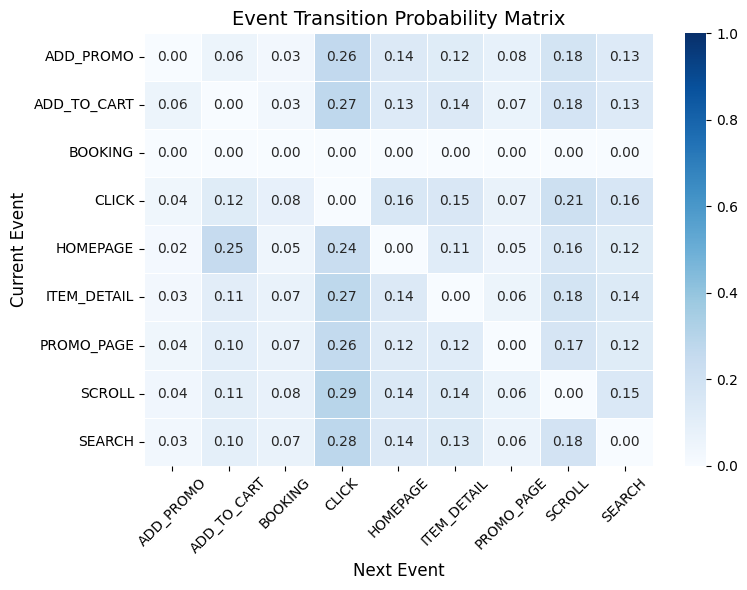

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    prob_df,
    annot=True,            # Show probabilities in cells
    fmt=".2f",            # Format as 2 decimal places
    cmap="Blues",         # Color scheme (Blues, YlOrRd, etc.)
    linewidths=0.5,       # Add grid lines
    cbar=True,            # Show color bar
    vmin=0, vmax=1        # Fix scale between 0 and 1
)

plt.title("Event Transition Probability Matrix", fontsize=14)
plt.xlabel("Next Event", fontsize=12)
plt.ylabel("Current Event", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# Get sessions with BOOKING events
booking_sessions = df[df['event_name'] == 'BOOKING']['session_id'].unique()

# Filter original data to only include these sessions
conversion_data = df[df['session_id'].isin(booking_sessions)]

# Group by traffic_source and count bookings
channel_conversions = conversion_data['traffic_source'].value_counts().reset_index()
channel_conversions.columns = ['traffic_source', 'bookings']

In [ ]:
# Count total sessions per channel
total_sessions = df.groupby('traffic_source')['session_id'].nunique().reset_index()
total_sessions.columns = ['traffic_source', 'total_sessions']

# Merge with bookings data
conversion_rates = pd.merge(channel_conversions, total_sessions, on='traffic_source')

# Calculate conversion rate
conversion_rates['conversion_rate'] = (conversion_rates['bookings'] / conversion_rates['total_sessions']) * 100  # as percentage

In [ ]:
conversion_rates = conversion_rates.sort_values('conversion_rate', ascending=False)
print(conversion_rates)

  traffic_source  bookings  total_sessions  conversion_rate
1            WEB    104923            6441      1628.986182
0         MOBILE    939214           58105      1616.408226


<ipython-input-46-a0f93471169d>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


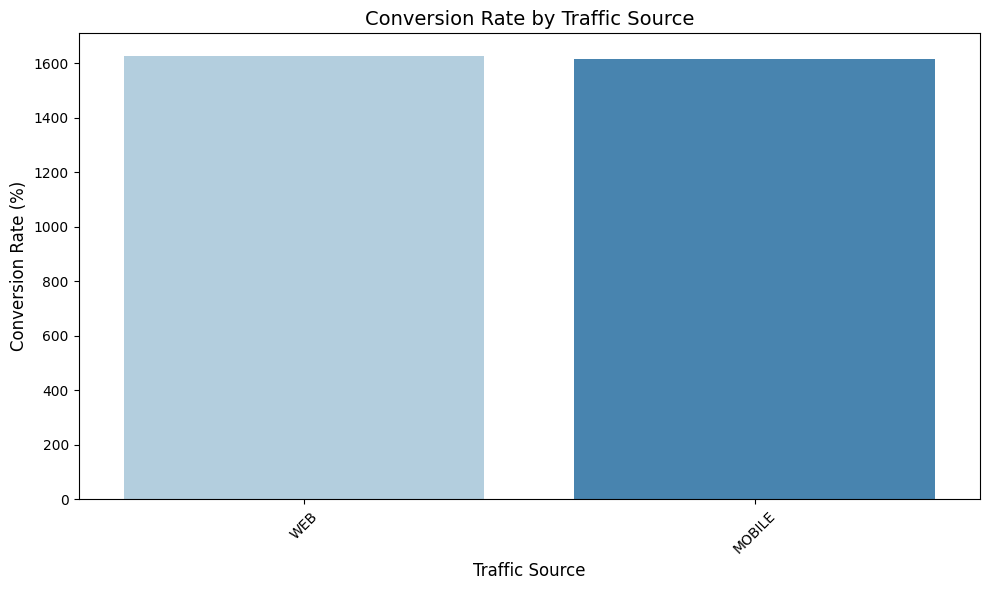

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(
    data=conversion_rates,
    x='traffic_source',
    y='conversion_rate',
    palette='Blues'
)
plt.title('Conversion Rate by Traffic Source', fontsize=14)
plt.xlabel('Traffic Source', fontsize=12)
plt.ylabel('Conversion Rate (%)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Get session_ids where BOOKING occurred
booking_sessions = df[df['event_name'] == 'BOOKING']['session_id'].unique()

# Filter the original DataFrame to only these sessions
booking_journeys = df[df['session_id'].isin(booking_sessions)]

In [ ]:
def get_last_touch_point(session_df):
    session_df = session_df.sort_values('event_time')  # Sort chronologically
    events = session_df['event_name'].tolist()
    if 'BOOKING' in events:
        booking_index = events.index('BOOKING')
        return events[booking_index - 1] if booking_index > 0 else None
    return None

# Group by session_id and apply the function
last_touch_points = booking_journeys.groupby('session_id').apply(get_last_touch_point).reset_index()
last_touch_points.columns = ['session_id', 'last_touch_event']

<ipython-input-48-ec6a4d29528f>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  last_touch_points = booking_journeys.groupby('session_id').apply(get_last_touch_point).reset_index()


In [ ]:
last_touch_counts = last_touch_points['last_touch_event'].value_counts().reset_index()
last_touch_counts.columns = ['last_touch_event', 'count']

# Calculate percentage
last_touch_counts['percentage'] = (last_touch_counts['count'] / last_touch_counts['count'].sum()) * 100
print(last_touch_counts)

  last_touch_event  count  percentage
0            CLICK  16102   25.107591
1           SCROLL  10469   16.324144
2      ADD_TO_CART   7842   12.227905
3           SEARCH   7802   12.165534
4      ITEM_DETAIL   7749   12.082892
5         HOMEPAGE   7692   11.994012
6       PROMO_PAGE   3456    5.388885
7        ADD_PROMO   3020    4.709038


<ipython-input-50-269bc7e64cc7>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


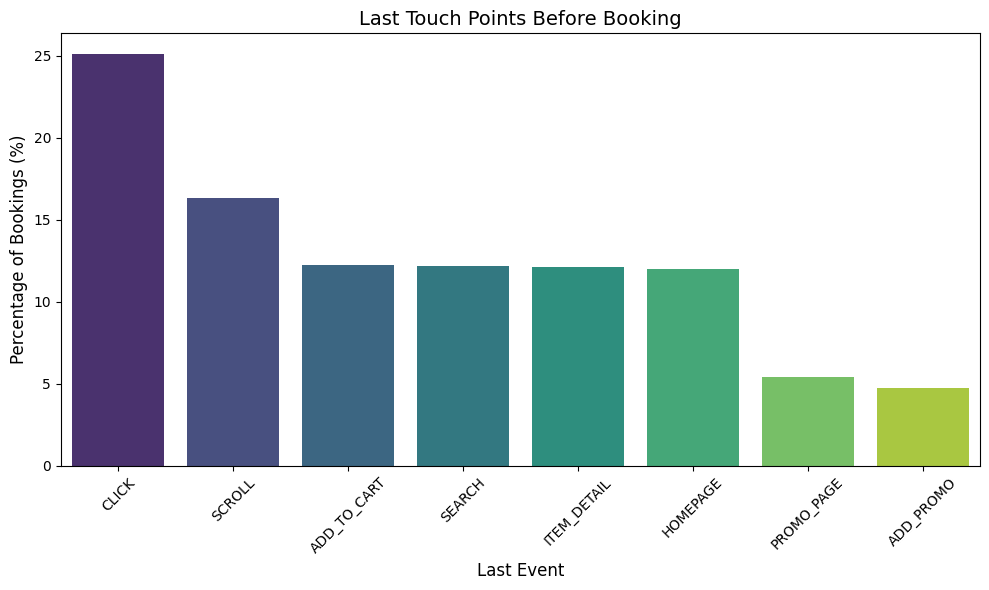

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(
    data=last_touch_counts,
    x='last_touch_event',
    y='percentage',
    palette='viridis'
)
plt.title('Last Touch Points Before Booking', fontsize=14)
plt.xlabel('Last Event', fontsize=12)
plt.ylabel('Percentage of Bookings (%)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [3]:
!pip install lifelines


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 7.9 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=706b97593e5d9c292e592a7794084435ae9043794cb6abe3549bbcfa81a82586
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


In [35]:
from lifelines import KaplanMeierFitter

In [84]:
import pandas as pd

#  Prepare data
df['event_time'] = pd.to_datetime(df['event_time'])
df = df.sort_values(['session_id', 'event_time'])
df['event_date'] = df['event_time'].dt.date

# Enhanced session calculation
def calculate_daily_sessions(group):
    daily_sessions = group.groupby('event_date').agg(
        session_start=('event_time', 'min'),
        session_end=('event_time', 'max'),
        event_count=('event_time', 'count'),
        events=('event_name', list)
    )
    daily_sessions['duration_min'] = (daily_sessions['session_end'] -
                                    daily_sessions['session_start']).dt.total_seconds() / 60
    return daily_sessions

#  Get booking details
booking_details = df[df['event_name'] == 'BOOKING'][['session_id', 'event_time', 'event_metadata']]
booking_details = booking_details.rename(columns={'event_time': 'booking_time'})

# Create comprehensive session info
session_info = (
    df.groupby('session_id')
    .apply(calculate_daily_sessions)
    .reset_index()
    .merge(
        booking_details,
        on='session_id',
        how='left'
    )
    .assign(
        converted=lambda x: ~x['booking_time'].isna(),
        time_to_convert=lambda x: (x['booking_time'] - x['session_start']).dt.total_seconds() / 60
    )
)

# Final converted sessions with all details
converted_sessions = (
    session_info[session_info['converted']]
    .sort_values('time_to_convert')
    .reset_index(drop=True)
)

<ipython-input-84-4dac0e2940f5>:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(calculate_daily_sessions)


In [85]:
survival_data = (
    session_info
    .sort_values(['session_id', 'session_start'])
    .groupby('session_id')
    .first()
    .reset_index()
)

# For sessions that converted, use their time_to_convert
# For non-converting sessions, use their duration_min as censored observations
survival_data['T'] = survival_data.apply(
    lambda x: x['time_to_convert'] if x['converted'] else x['duration_min'],
    axis=1
)
survival_data['E'] = survival_data['converted'].astype(int)  # 1 if converted, 0 if censored

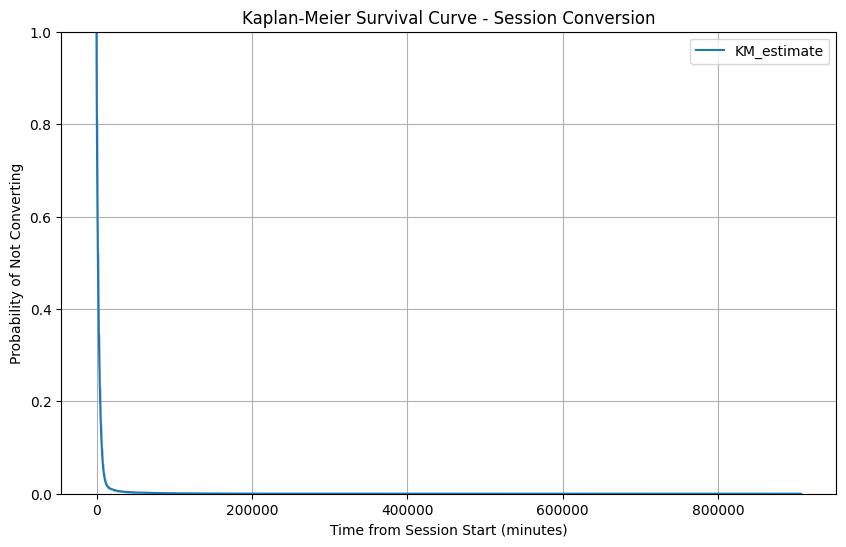

In [86]:
# Initialize and fit the model
kmf = KaplanMeierFitter()
kmf.fit(survival_data['T'], event_observed=survival_data['E'])

# Plot the survival curve
plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curve - Session Conversion')
plt.xlabel('Time from Session Start (minutes)')
plt.ylabel('Probability of Not Converting')
plt.ylim(0, 1)
plt.grid(True)
plt.show()

In [88]:
# Median conversion time
median_conversion_time = kmf.median_survival_time_
print(f"Median conversion time: {median_conversion_time:.1f} minutes")

# Survival probabilities at specific time points
time_points = [1, 5, 10, 15, 30, 60,120]  # minutes
for t in time_points:
    prob = kmf.predict(t)
    print(f"After {t} minutes: {prob:.1%} of sessions haven't converted")



Median conversion time: 1875.8 minutes
After 1 minutes: 99.9% of sessions haven't converted
After 5 minutes: 99.5% of sessions haven't converted
After 10 minutes: 99.1% of sessions haven't converted
After 15 minutes: 98.7% of sessions haven't converted
After 30 minutes: 97.6% of sessions haven't converted
After 60 minutes: 95.7% of sessions haven't converted
After 120 minutes: 92.8% of sessions haven't converted


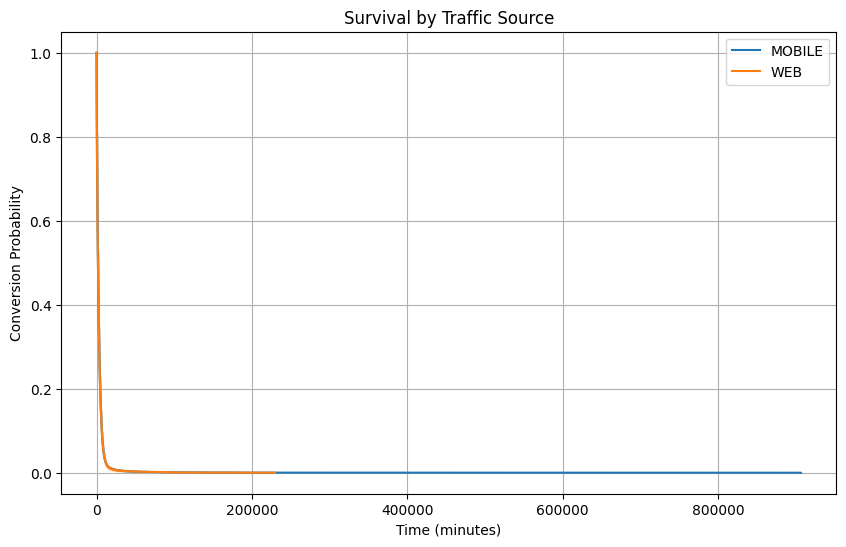

In [89]:
# Add traffic source if available (from original df)
survival_data = survival_data.merge(
    df[['session_id', 'traffic_source']].drop_duplicates(),
    on='session_id',
    how='left'
)

# Plot separate curves for each group
plt.figure(figsize=(10, 6))
for source in survival_data['traffic_source'].unique():
    mask = survival_data['traffic_source'] == source
    kmf.fit(survival_data.loc[mask, 'T'],
            event_observed=survival_data.loc[mask, 'E'],
            label=source)
    kmf.plot_survival_function()

plt.title('Survival by Traffic Source')
plt.xlabel('Time (minutes)')
plt.ylabel('Conversion Probability')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
print(df['event_time'] )

0         2019-09-06 15:54:32.821085+00:00
1         2019-09-06 16:03:57.821085+00:00
2         2019-09-01 12:05:10.322763+00:00
3         2019-09-01 12:06:33.322763+00:00
4         2019-09-01 12:15:29.425431+00:00
                        ...               
1048570   2021-08-13 10:03:50.182283+00:00
1048571   2021-08-13 10:16:27.182283+00:00
1048572   2021-08-13 10:29:26.182283+00:00
1048573   2021-08-13 10:42:28.182283+00:00
1048574   2021-08-13 10:54:35.182283+00:00
Name: event_time, Length: 1048575, dtype: datetime64[ns, UTC]


In [72]:
df['event_date'] = pd.to_datetime(df['event_time']).dt.date

In [73]:
# Group by both session_id and date
session_durations = (df.groupby(['session_id', 'event_date'])['event_time']
                     .agg(['min', 'max'])
                     .reset_index())

In [76]:
# Calculate duration in minutes (within same day)
session_durations['duration'] = (
    pd.to_datetime(session_durations['max']) -
    pd.to_datetime(session_durations['min'])
).dt.total_seconds() / 60

In [77]:
print(session_durations['duration'])

0          483.333333
1          966.483333
2          969.733333
3          990.116667
4            0.000000
             ...     
205737     710.316667
205738     707.983333
205739       0.000000
205740    1091.833333
205741     225.083333
Name: duration, Length: 205742, dtype: float64


In [78]:
booking_sessions = df[df['event_name'] == 'BOOKING']['session_id'].unique()

In [79]:
def calculate_daily_sessions(group):
    daily_sessions = group.groupby('event_date').agg(
        session_start=('event_time', 'min'),
        session_end=('event_time', 'max')
    )
    daily_sessions['duration_min'] = (daily_sessions['session_end'] - daily_sessions['session_start']).dt.total_seconds() / 60
    return daily_sessions

In [80]:
def calculate_daily_sessions(group):
    daily_sessions = group.groupby('event_date').agg(
        session_start=('event_time', 'min'),
        session_end=('event_time', 'max')
    )
    daily_sessions['duration_min'] = (daily_sessions['session_end'] - daily_sessions['session_start']).dt.total_seconds() / 60
    return daily_sessions

In [81]:
session_info = (
    df.groupby('session_id')
    .apply(calculate_daily_sessions)
    .reset_index()
    .merge(
        pd.DataFrame({'session_id': booking_sessions, 'converted': 1}),
        on='session_id',
        how='left'
    )
    .fillna({'converted': 0})
)

<ipython-input-81-7ebce7efb04f>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(calculate_daily_sessions)


In [82]:
converted_sessions = session_info[session_info['converted'] == 1]

In [83]:
print(converted_sessions[['session_id', 'event_date', 'duration_min']])

                                  session_id  event_date  duration_min
0       00001f29-3ede-4445-95f0-0178934e32ba  2019-05-17    483.333333
1       00001f29-3ede-4445-95f0-0178934e32ba  2019-05-18    966.483333
2       00001f29-3ede-4445-95f0-0178934e32ba  2019-05-19    969.733333
3       0001971f-84ae-4bac-9612-366c5f241167  2020-08-16    990.116667
4       0001971f-84ae-4bac-9612-366c5f241167  2020-08-17      0.000000
...                                      ...         ...           ...
205737  fffe8be9-eef6-491c-b17c-07391bbf2387  2019-01-20    710.316667
205738  fffe8be9-eef6-491c-b17c-07391bbf2387  2019-01-21    707.983333
205739  fffe8be9-eef6-491c-b17c-07391bbf2387  2019-01-22      0.000000
205740  ffff284a-9364-4296-a758-e3b0b4297f6d  2017-03-29   1091.833333
205741  ffff284a-9364-4296-a758-e3b0b4297f6d  2017-03-30    225.083333

[205316 rows x 3 columns]


In [37]:
session_durations = df.groupby('session_id')['event_time'].agg(['min', 'max'])

In [38]:
session_durations['duration'] = (session_durations['max'] - session_durations['min']).dt.total_seconds() / 60

In [45]:
print(session_durations['duration'])

session_id
00001f29-3ede-4445-95f0-0178934e32ba     3385.200000
0001971f-84ae-4bac-9612-366c5f241167     1264.950000
000288dc-e7cf-44b9-9f2d-270015fd83c6     1166.866667
0002ad9d-3c59-4c9c-b6dc-ae6a561ef718      844.933333
0004012d-a905-4411-9ed4-2f80778feafe     7194.616667
                                            ...     
fffc91d9-5189-4a52-8efa-a8aef79800ab      753.150000
fffd5e4b-0141-47d1-9c8f-b3f601977b02    13706.383333
fffdbe04-e042-4859-9336-7cf4eda9a1f3     4968.716667
fffe8be9-eef6-491c-b17c-07391bbf2387     4226.316667
ffff284a-9364-4296-a758-e3b0b4297f6d     1349.066667
Name: duration, Length: 64546, dtype: float64


In [39]:
# Determine if session ended with a BOOKING event (conversion)
session_conversion = df[df['event_name'] == 'BOOKING'].groupby('session_id').size().reset_index(name='converted')
session_conversion['converted'] = 1


In [60]:
# Merge session durations with conversion data
survival_data = session_durations.merge(session_conversion,
                                       on='session_id',
                                       how='left').fillna(0)

# Create event observation (1 if converted, 0 if censored)
survival_data['converted'] = survival_data['converted'].astype(int)

# Duration in minutes
survival_data['duration_min'] = survival_data['duration']

In [71]:
print(survival_data['duration_min'].describe())
print("95th percentile:", survival_data['duration_min'].quantile(0.95))

count     64546.000000
mean       4176.284722
std        9017.016548
min           0.016667
25%         831.337500
50%        2453.425000
75%        5315.812500
max      906893.600000
Name: duration_min, dtype: float64
95th percentile: 12350.791666666666


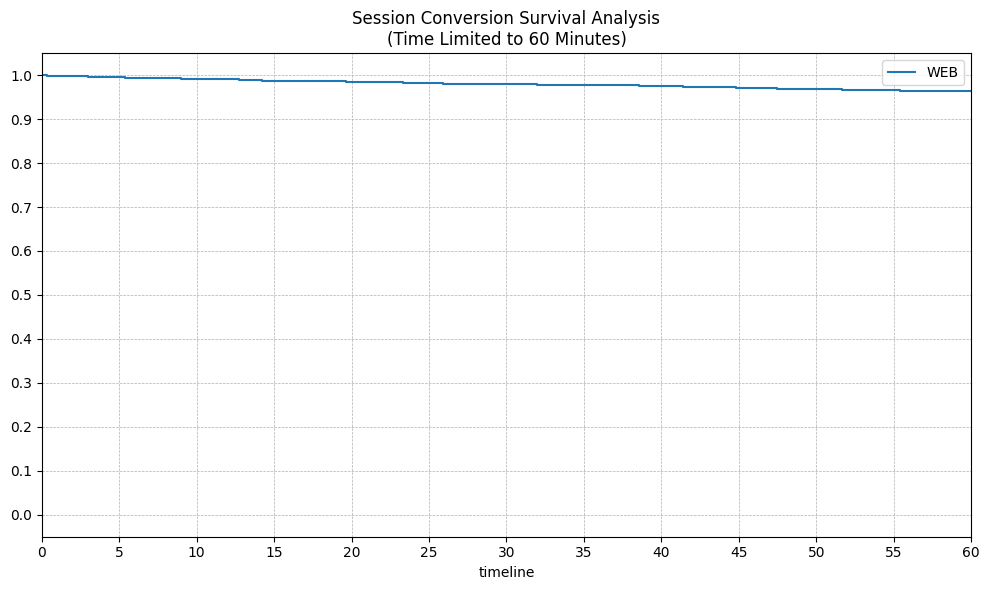

In [70]:
# # Initialize KaplanMeierFitter
# kmf = KaplanMeierFitter()

# # Fit the data
# kmf.fit(survival_data['duration_min'],
#         event_observed=survival_data['converted'],
#         label='Kaplan Meier Estimate')

# # Plot the survival function
# kmf.plot_survival_function()
# plt.title('Survival Function of User Sessions')
# plt.xlabel('Session Duration (minutes)')
# plt.ylabel('Probability of Not Converting')
# plt.show()

plt.figure(figsize=(10, 6))
kmf.plot_survival_function(ci_show=False)  # Cleaner without confidence intervals

# Set intelligent bounds based on your data
x_max = min(60, survival_data['duration_min'].quantile(0.95))  # 95th percentile or 60min
plt.xlim(0, x_max)

# Custom grid and ticks
plt.xticks(np.arange(0, x_max+1, 5))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.title('Session Conversion Survival Analysis\n(Time Limited to {} Minutes)'.format(x_max))
plt.tight_layout()
plt.show()

In [62]:
median_survival_time = kmf.median_survival_time_
print(f"Median conversion time: {median_survival_time} minutes")

Median conversion time: 2479.633333333333 minutes


In [64]:
time_points = [1, 5, 10, 15,60,120,2880]  # in minutes
survival_prob = kmf.predict(time_points)
print(f"Survival probabilities at {time_points} minutes: {survival_prob}")

Survival probabilities at [1, 5, 10, 15, 60, 120, 2880] minutes: 1       0.999024
5       0.996126
10      0.992404
15      0.989176
60      0.964619
120     0.941237
2880    0.452273
Name: Kaplan Meier Estimate, dtype: float64


In [66]:
survival_data = survival_data.merge(
    df[['session_id', 'traffic_source']].drop_duplicates(),
    on='session_id',
    how='left'
)

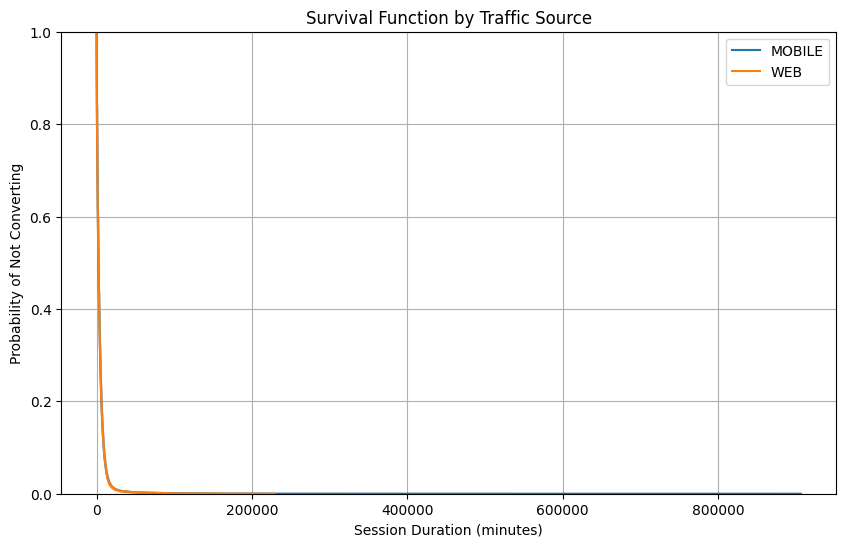

In [67]:
# Create a figure
plt.figure(figsize=(10, 6))

# Fit and plot for each group
groups = survival_data['traffic_source'].unique()
for group in groups:
    group_data = survival_data[survival_data['traffic_source'] == group]
    kmf.fit(group_data['duration_min'],
            event_observed=group_data['converted'],
            label=group)
    kmf.plot_survival_function()

plt.title('Survival Function by Traffic Source')
plt.xlabel('Session Duration (minutes)')
plt.ylabel('Probability of Not Converting')
plt.ylim(0, 1)
plt.grid(True)
plt.show()

In [69]:
summary_data = []

for group in groups:
    group_data = survival_data[survival_data['traffic_source'] == group]
    kmf.fit(group_data['duration_min'], group_data['converted'])

    summary_data.append({
        'Group': group,
        'Median Survival Time': kmf.median_survival_time_,
        '1-min Survival Probability': kmf.predict(1),
        '5-min Survival Probability': kmf.predict(5),
        '2880-min Survival Probability': kmf.predict(2880),
        'Conversion Rate': group_data['converted'].mean()
    })

pd.DataFrame(summary_data)

,Group,Median Survival Time,1-min Survival Probability,5-min Survival Probability,2880-min Survival Probability,Conversion Rate
0,MOBILE,2485.950000,0.999088,0.996247,0.45275,0.993529
1,WEB,2426.633333,0.998447,0.995031,0.44797,0.994100
